# Universität Mannheim
### Course: Industrial Applications of AI
Third assignment submission by: Gian Lorenzo Marchioni

## Predictive Process Monitoring using LSTMs

This project aims to leverage ML techniques on business process event logs to predict remaining processing times. This can yield insights into process efficiency and management, as well as a useful tool for providing estimated completion times to customers.

### Specific Objectives:
- **Data Processing**: Utilize `pm4py`, a powerful Python library designed for process mining, to handle and perform feature engineering on the event log data efficiently. This involves extracting relevant features that can provide meaningful inputs for predictive models.
- **Model Development**: Configure and train a `Keras Sequential` model to predict the remaining time for business process instances. This approach will help in estimating the duration until the completion of ongoing processes.

References:   
- [Navarin et al.] - N. Navarin, B. Vincenzi, M. Polato, and A. Sperduti, "LSTM networks for data-aware remaining time prediction of business process instances," 2017 IEEE Symposium Series on Computational Intelligence (SSCI), Honolulu, HI, USA, 2017, pp. 1-7, doi: 10.1109/SSCI.2017.8285184.
- [Metzger et al.] - A. Metzger and A. Neubauer, "Considering Non-sequential Control Flows for Process Prediction with Recurrent Neural Networks," 2018 44th Euromicro Conference on Software Engineering and Advanced Applications (SEAA), Prague, Czech Republic, 2018, pp. 268-272, doi: 10.1109/SEAA.2018.00051.
- [Rama-Maneiro et al.] - E. Rama-Maneiro, J. C. Vidal and M. Lama, "Deep Learning for Predictive Business Process Monitoring: Review and Benchmark," in IEEE Transactions on Services Computing, vol. 16, no. 1, pp. 739-756, 1 Jan.-Feb. 2023, doi: 10.1109/TSC.2021.3139807.
- [Adriansyah and Buijs] - Adriansyah, A., & Buijs, J.C.A.M. (2012). Mining Process Performance from Event Logs: The BPI Challenge 2012 Case Study. Department of Mathematics and Computer Science, Eindhoven University of Technology. Available online: [BPI Challenge 2012](https://www.win.tue.nl/bpi/2012/adriansyah.pdf)
- [Verbeek] - Verbeek, H.M.W. (2012). BPI Challenge 2012: The Transition System Case. Department of Mathematics and Computer Science, Technische Universiteit Eindhoven. Available online: [BPI Challenge 2012 Verbeek](https://www.win.tue.nl/bpi/2012/verbeek.pdf)
- [Dadashnia et al.] - Dadashnia, S., Fettke, P., Hake, P., Lahann, J., Loos, P., Klein, S., Mehdiyev, N., Niesen, T., Rehse, J.-R., & Zapp, M. (2017). Exploring the Potentials of Artificial Intelligence Techniques for Business Process Analysis. Institute for Information Systems at the German Research Center for Artificial Intelligence (DFKI), Saarbrücken, Germany. Available online: [BPI 2017 Paper 41](https://aismuseum.win.tue.nl/bpi/2017/bpi2017_paper_41.pdf)
- [Bose and van der Aalst] - R.P. Jagadeesh Chandra Bose and Wil M.P. van der Aalst, "Process Mining Applied to the BPI Challenge 2012: Divide and Conquer While Discerning Resources," Department of Mathematics and Computer Science, Eindhoven University of Technology, The Netherlands. Available: [BPI Challenge 2012 Jagadeesh](http://bpmcenter.org/wp-content/uploads/reports/2012/BPM-12-16.pdf).

### Dataset:    
[BPI 2012](https://data.4tu.nl/datasets/533f66a4-8911-4ac7-8612-1235d65d1f37)  
It is a popular dataset in process mining. Provided by a Dutch financial institute, it contains data from a loan application process.

Log Description:  
The event log contains events related to an application proces. Events actually belong to three intertwined subprocesses, which can be distinguished by the first letter of each event name (A, O and W). The A subprocess is concerned with handling the applications themselves. The O subprocess handles offers send to customers for certain applications. The W process describes how work items, belonging to the application, are processed.  

The usual activity flow is as follows:  
- An application is submitted through a webpage.
- Automatic checks are performed, after which the application is complemented with additional information obtained by contacting the customer.  
- If an applicant is eligible, an offer is sent to the client by mail.   
- The offer is then received back and assessed.  
- If incomplete, missing information is added by again contacting the customer.  
- A final assessment is conducted, after which the application is approved and activated.  

Detailed Explanation of Event Log Columns:
- **org:resource** Identifier of the resource (employee or system component) handling the event.
- **lifecycle:transition** Represents the stage of the activity:
    - **COMPLETE**: The task (of type A- or O-) is completed.
    - **SCHEDULE**: The work item (of type W-) is created in the queue (automatic step following manual actions).
    - **START**: The work item (of type W-) is obtained by the resource.
    - **COMPLETE** (Work Item): The work item (of type W-) is released by the resource and put back in the queue or transferred to another queue (SCHEDULE).
- **concept:name** Describes the specific activity performed:
    - **States starting with A-**: States of the application.
    - **States starting with O-**: States of the offer belonging to the application.
    - **States starting with W-**: States of the work item belonging to the application.
    - Useful Translations:
        - **W_Completeren aanvraag** ("Complete application")
        - **W_Nabellen offertes** ("Call back for quotes")
        - **W_Nabellen incomplete dossiers** ("Call back for incomplete files")
        - **W_Valideren aanvraag** ("Validate application")
        - **W_Afhandelen leads** ("Handle leads")
        - **W_Beoordelen fraude** ("Assess fraud")
        - **W_Wijzigen contractgegevens** ("Change contract details")   
- **time:timestamp** Records the exact date and time when an event occurred.
- **case:REG_DATE** Date when the case was registered in the system.
- **case:concept:name** Anonymized applicant name for each case (process instance).
- **case:AMOUNT_REQ** The amount requested in the application.
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from pm4py.algo.transformation.log_to_target import algorithm as log_to_target

import warnings

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import LSTM, Masking
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# To ignore warnings related to deprecated functionalities in PM4PY
warnings.filterwarnings("ignore")

***
## Data preprocessing and EDA

In [2]:
log_df = pm4py.read_xes('BPI_Challenge_2012.xes')

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [3]:
# I will translate the dutch terms for easier understanding
# Define a dictionary with Dutch terms and their English translations
translations = {
    'W_Completeren aanvraag': 'W_Complete application',
    'W_Nabellen offertes': 'W_Call back for quotes',
    'W_Nabellen incomplete dossiers': 'W_Call back for incomplete files',
    'W_Valideren aanvraag': 'W_Validate application',
    'W_Afhandelen leads': 'W_Handle leads',
    'W_Beoordelen fraude': 'W_Assess fraud',
    'W_Wijzigen contractgegevens': 'W_Change contract details'
}

# Apply translations to the activity column
log_df['concept:name'] = log_df['concept:name'].replace(translations)
log_df['concept:name'] = log_df['concept:name'].replace(r's+', 'empty', regex=True)

log_df['case:AMOUNT_REQ']=pd.to_numeric(log_df['case:AMOUNT_REQ'])

In [4]:
log_df[log_df['case:concept:name']=='173688']

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
3,112,SCHEDULE,W_Complete application,2011-10-01 00:39:38.875000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
4,NaN,START,W_Complete application,2011-10-01 11:36:46.437000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
5,10862,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
6,10862,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
7,10862,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
8,10862,COMPLETE,O_CREATED,2011-10-01 11:45:11.197000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
9,10862,COMPLETE,O_SENT,2011-10-01 11:45:11.380000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000


In [5]:
log_df[log_df['case:concept:name']=='214370']

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
262171,112,COMPLETE,A_SUBMITTED,2012-02-29 23:28:55.349000+00:00,2012-02-29 23:28:55.349000+00:00,214370,20000
262172,112,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:28:55.479000+00:00,2012-02-29 23:28:55.349000+00:00,214370,20000
262173,112,SCHEDULE,W_Handle leadempty,2012-02-29 23:29:06.452000+00:00,2012-02-29 23:28:55.349000+00:00,214370,20000
262174,11169,START,W_Handle leadempty,2012-03-01 09:25:39.409000+00:00,2012-02-29 23:28:55.349000+00:00,214370,20000
262175,11169,COMPLETE,A_DECLINED,2012-03-01 09:28:18.168000+00:00,2012-02-29 23:28:55.349000+00:00,214370,20000
262176,11169,COMPLETE,W_Handle leadempty,2012-03-01 09:28:21.228000+00:00,2012-02-29 23:28:55.349000+00:00,214370,20000


In [6]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262200 entries, 0 to 262199
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   org:resource          244190 non-null  object             
 1   lifecycle:transition  262200 non-null  object             
 2   concept:name          262200 non-null  object             
 3   time:timestamp        262200 non-null  datetime64[ns, UTC]
 4   case:REG_DATE         262200 non-null  datetime64[ns, UTC]
 5   case:concept:name     262200 non-null  object             
 6   case:AMOUNT_REQ       262200 non-null  int64              
dtypes: datetime64[ns, UTC](2), int64(1), object(4)
memory usage: 14.0+ MB


***
## Dataset Observations

### Initial Observations:
- **Start of Cases**: Each case in the dataset initiates with the activity 'A_SUBMITTED', which is consistently executed by user '112'. This resource is also responsible for all instances of 'A_PARTLYSUBMITTED'.
- **Resource Assignment**: Any events that lack specified resources are systematically assigned a resource identifier of '0', ensuring there are no null values in the resource field.

### Process Characteristics:
- **Process Variation**: The length of processes varies significantly across the dataset. Prolonged cases are often attributed to frequent callbacks to clients, primarily for additional quotes or to supplement incomplete files.
- **Lifecycle Transition**: The `lifecycle:transition` column, initially considered for analysis, does not yield insights into the outcomes of applications but merely indicates the progression of activities, particularly those prefixed with 'W_'. Consequently, this column is excluded from the analysis to maintain focus on more impactful attributes.

### Data Filtering:
- **Event Selection**: The event log is curated to include only events marked as `COMPLETE`, ensuring the analysis is confined to fully executed activities.
- **Column Exclusion**: The `lifecycle:transition` column is omitted from the dataset post-filtering due to its limited relevance to the outcome or overall flow of the business processes.


In [7]:
log_df['org:resource'] = log_df['org:resource'].fillna(0)

log_df=log_df[log_df['lifecycle:transition']=='COMPLETE']
log_df=log_df.drop(columns=['lifecycle:transition']).reset_index(drop=True)

──────────────────────────────────────────────────
Total Events in the Log: 164506
Unique Cases (i.e. Process Instances): 13087
──────────────────────────────────────────────────
Average number of actions in a process instance: 12
Minimum number of actions in a process instance: 3
Maximum number of actions in a process instance: 96
──────────────────────────────────────────────────


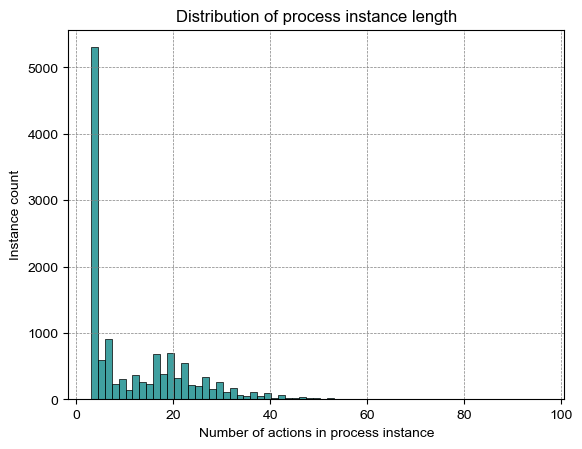

In [8]:
# A brief descriptive summary of the length of process instances in the dataset
grouped_df=log_df.groupby(by='case:concept:name').count()
avg_n_actions=int(grouped_df['concept:name'].mean())
min_n_actions=int(grouped_df['concept:name'].min())
max_n_actions=int(grouped_df['concept:name'].max())
n_cases=len(grouped_df)
print('─'*50)
print(f'Total Events in the Log: {len(log_df)}')
print(f'Unique Cases (i.e. Process Instances): {n_cases}')
print('─'*50)
print(f'Average number of actions in a process instance: {avg_n_actions}')
print(f'Minimum number of actions in a process instance: {min_n_actions}')
print(f'Maximum number of actions in a process instance: {max_n_actions}')
print('─'*50)

plt.rcParams['font.sans-serif'] = 'Arial'
sns.histplot(grouped_df, x='concept:name', color='#008080')
plt.xlabel('Number of actions in process instance')
plt.ylabel('Instance count')
plt.title('Distribution of process instance length')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

plt.show()

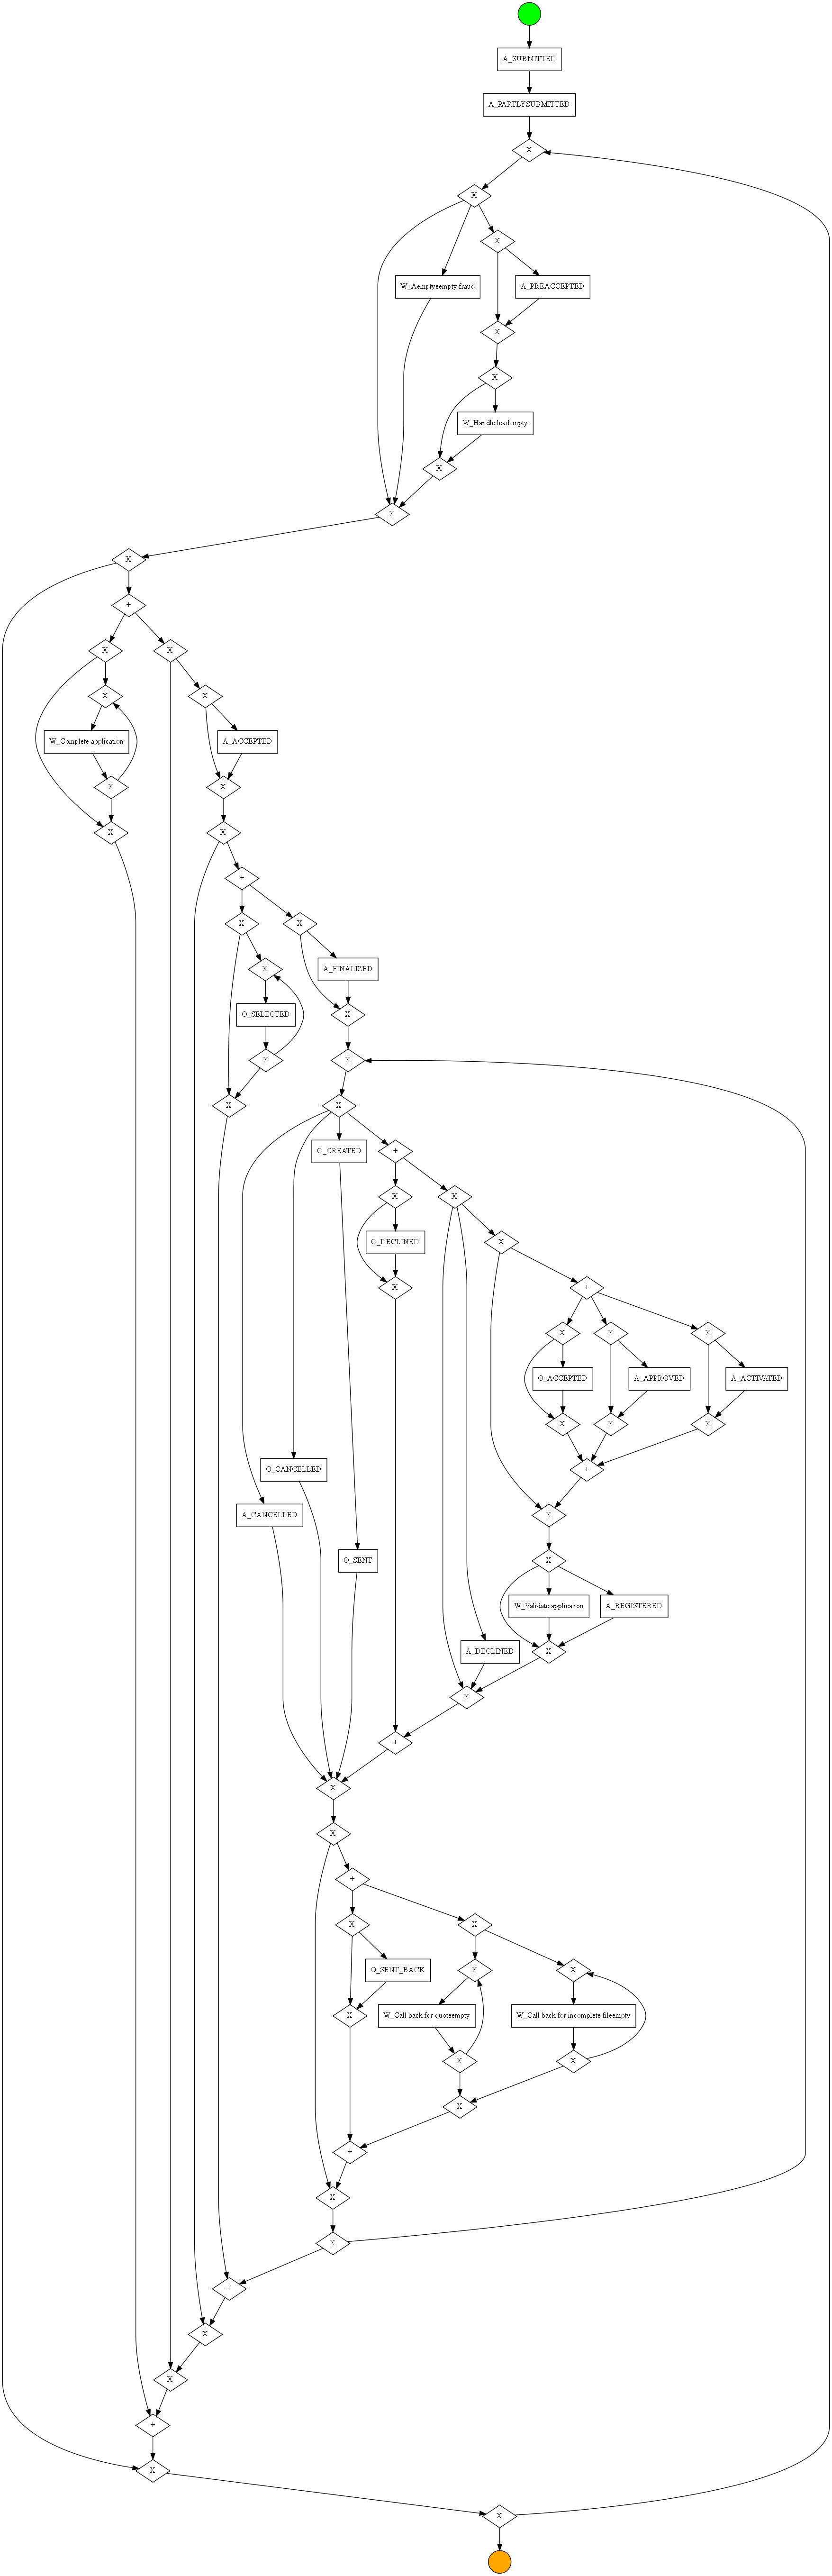

In [9]:
process_model = pm4py.discover_bpmn_inductive(log_df)
pm4py.view_bpmn(process_model, rankdir='TB')
# pm4py.save_vis_bpmn(bpmn_graph=process_model, file_path='bpi_bpmn.png', rankdir='TB')

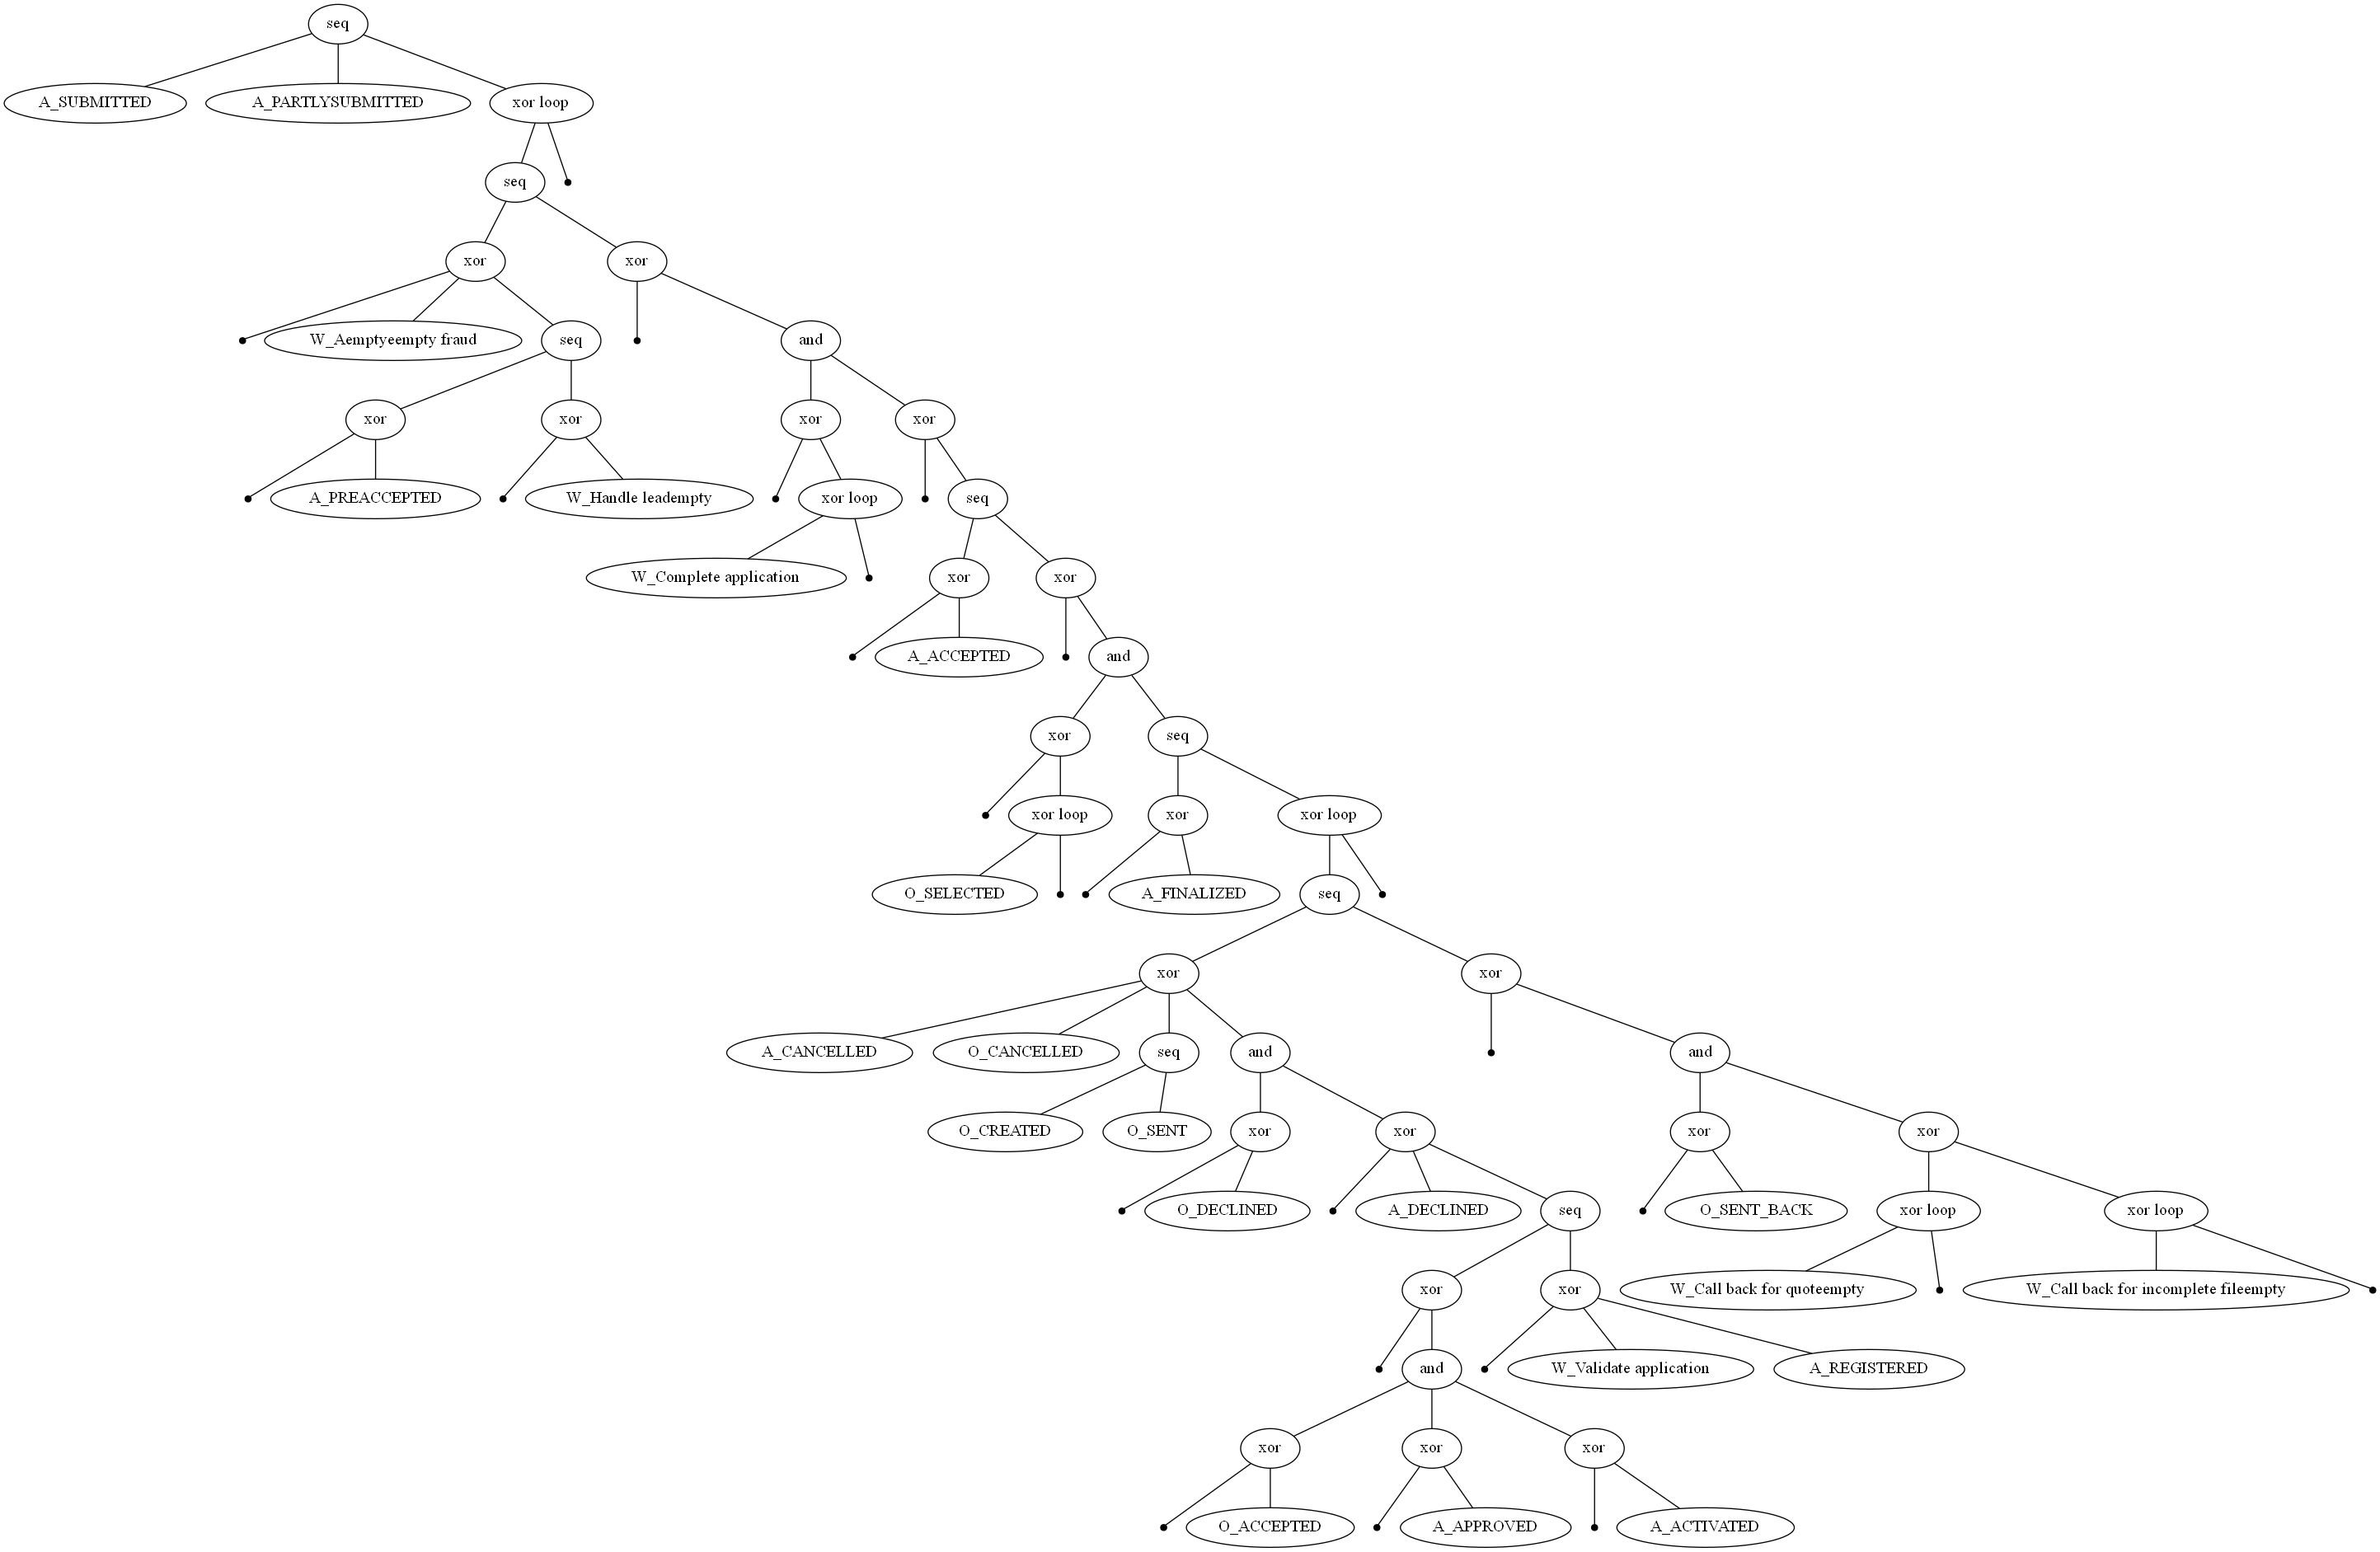

In [10]:
process_tree = pm4py.discover_process_tree_inductive(log_df)
pm4py.view_process_tree(process_tree, rankdir='TB')
# pm4py.save_vis_process_tree(tree=process_tree, file_path='bpi_process_tree.png', rankdir='TB')

***
## Application Outcomes

Understanding the outcomes of process instances is crucial for building predictive models. The categorization of outcomes into four distinct labels provides a clear framework for analyzing the dataset. These labels, mentioned by [Bose and van der Aalst], include:
- **Approved**: Instances where the process has been successfully completed.
- **Declined**: Instances where the process has been explicitly rejected.
- **Cancelled**: Cases where the process was terminated before completion.
- **Undecided**: Ongoing cases that have not reached a conclusion.

The method for determining these outcomes is not explicitly detailed in the available documentation, possibly referenced in the now-inaccessible 2012 challenge documentation. By analyzing the last 'A_' prefixed activity for each case, it was possible to replicate the outcome frequencies indicated by [Bose and van der Aalst]. It is important to note that the sequence of activities in a process can affect outcome determination. For example, an activity labeled as `A_FINALIZED` might subsequently be followed by `A_CANCELLED`, indicating that simply the first occurrence of a concluding activity is not always definitive of the outcome.

For predictive modeling purposes, cases labeled as 'Undecided' are omitted from the dataset used for training and evaluation. This exclusion is based on the assumption that these cases represent incomplete or still-active process instances, which could introduce bias or uncertainty into the model.

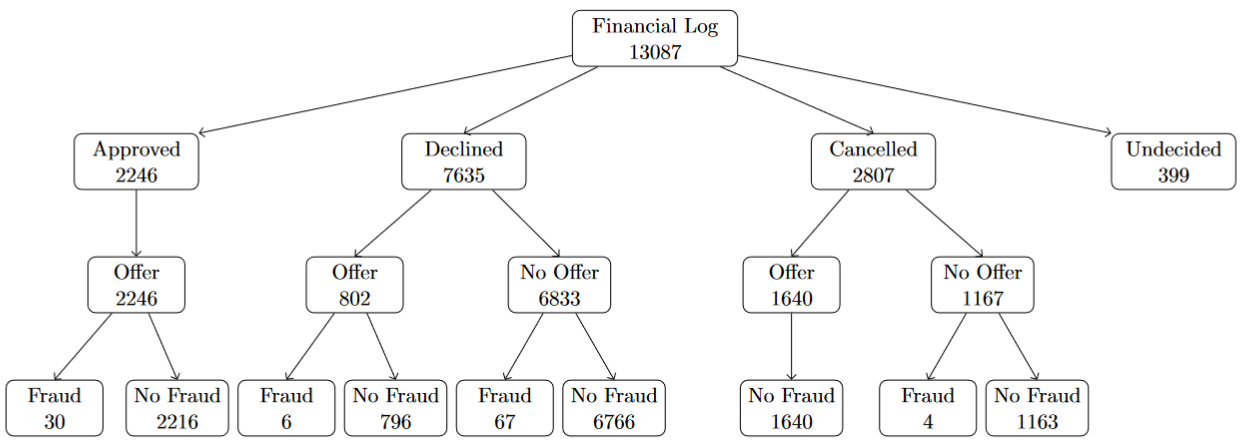

In [11]:
filtered_log = log_df[log_df['concept:name'].str.startswith('A_')]

# Group by case and get the last 'A_' activity for each case
last_activity_per_case = filtered_log.groupby('case:concept:name')['concept:name'].last()

# Assign labels based on the last 'A_' activity
outcomes = last_activity_per_case.map({
    'A_APPROVED': 'Approved',
    'A_ACTIVATED': 'Approved',
    'A_REGISTERED': 'Approved',
    'A_DECLINED': 'Declined',
    'A_CANCELLED': 'Cancelled'
}).fillna('Undecided')  # Default to 'Undecided'

# Create a new DataFrame with outcomes
outcome_df = pd.DataFrame({
    'case:concept:name': outcomes.index,
    'outcome': outcomes.values
})

outcome_df.groupby('outcome').count()

,case:concept:name
outcome,
Approved,2246
Cancelled,2807
Declined,7635
Undecided,399


In [12]:
# Merge the log_df with outcome_df on 'case:concept:name'
log_df = pd.merge(log_df, outcome_df, on='case:concept:name', how='left')

# Filter rows where the outcome is not 'Undecided'
log_df = log_df[log_df['outcome'] != 'Undecided']

***
## Feature Selection

The approach for feature selection in this project is derived from the method presented by [Navarin et al.] in their research on LSTM networks for data-aware remaining time prediction in business process instances.

#### Features Defined:
- **Activities**: Each activity within an event is one-hot encoded to capture its unique contribution to the process.
- **Resource**: Similar to activities, resources involved in each event are one-hot encoded to reflect their impact on the process timeline.
- **Requested Amount**: This feature represents the monetary amount associated with each process, considered at the trace level and represented as an integer.
- **Total Elapsed Time**: Captures the cumulative time passed since the beginning of the trace up to each event, measured in seconds.
- **Time from Last Activity**: Indicates the time elapsed since the last recorded event in the trace, also measured in seconds.
- **Weekday of Activity**: Encoded as an integer, this feature reflects the day of the week for each event, which might influence processing times due to variability in work schedules.
- **Concurrent Instances**: Counts the number of simultaneous processes active at the time of each event, providing insight into resource load and potential bottlenecks.

#### Data Preparation Steps:
- **Event Log Conversion**: Utilizing pm4py's `log_converter.apply()`, the dataset is converted from a DataFrame into an event log format suitable for process mining.
- **Feature Encoding**: Event level features are emphasized for the sequential model, necessitating precise application of pm4py's `log_to_features.apply()`. This function allows for the integration of trace level attributes directly at the event level, alongside calculations for metrics such as total elapsed time, time since the last event, and weekday detection.

In [13]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156962 entries, 0 to 164505
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   org:resource       156962 non-null  object             
 1   concept:name       156962 non-null  object             
 2   time:timestamp     156962 non-null  datetime64[ns, UTC]
 3   case:REG_DATE      156962 non-null  datetime64[ns, UTC]
 4   case:concept:name  156962 non-null  object             
 5   case:AMOUNT_REQ    156962 non-null  int64              
 6   outcome            156962 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(1), object(4)
memory usage: 9.6+ MB


In [14]:
log_df = log_df.sort_values('time:timestamp').reset_index(drop=True)
# Initialize the column for counting process instances
log_df['n_instances'] = 0

# Iterate over each row to count overlapping processes
for index, row in log_df.iterrows():
    current_time = row['time:timestamp']
    concurrent_count = log_df[(log_df['time:timestamp'] <= current_time) & (log_df['time:timestamp'] >= current_time)].shape[0]
    log_df.at[index, 'n_instances'] = concurrent_count

log_df[log_df['case:concept:name']=='173688']

,org:resource,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ,outcome,n_instances
0,112,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,1
1,112,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,1
2,112,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,1
63,10862,A_ACCEPTED,2011-10-01 11:42:43.308000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,1
66,10862,O_SELECTED,2011-10-01 11:45:09.243000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,2
67,10862,A_FINALIZED,2011-10-01 11:45:09.243000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,2
68,10862,O_CREATED,2011-10-01 11:45:11.197000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,1
69,10862,O_SENT,2011-10-01 11:45:11.380000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,1
70,0,W_Complete application,2011-10-01 11:45:13.917000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,1
80,0,W_Call back for quoteempty,2011-10-01 12:17:08.924000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000,Approved,1


In [15]:
log_df.drop(columns=['outcome'], inplace=True)
log = log_converter.apply(log_df, variant=log_converter.Variants.TO_EVENT_LOG)

for trace in log:
    reg_time = trace.attributes['REG_DATE'] 
    last_event_time=reg_time
    for event in trace:
        # Adding case attributes to each event
        event['case_id']=int(trace.attributes['concept:name'])
        event['AMOUNT_REQ'] = trace.attributes['AMOUNT_REQ']
        event['time_since_reg'] = (event['time:timestamp'] - reg_time).total_seconds()
        event['time_since_last_event'] = (event['time:timestamp'] - last_event_time).total_seconds()
        event['weekday'] = event['time:timestamp'].weekday() # returns encoded day of the week with Monday=0, Sunday=6
        
        last_event_time=event['time:timestamp']

parameters = {
    "str_ev_attr": ["concept:name", "org:resource"],
    "num_ev_attr": ["time_since_reg", 'time_since_last_event', "AMOUNT_REQ", 'weekday', "case_id", 'n_instances']  
}

feature_data, feature_names = log_to_features.apply(log, variant=log_to_features.Variants.EVENT_BASED, parameters=parameters)

print(feature_data.shape)
print(feature_names)

(12688, 96, 97)
['event:AMOUNT_REQ', 'event:case_id', 'event:concept:name@A_ACCEPTED', 'event:concept:name@A_ACTIVATED', 'event:concept:name@A_APPROVED', 'event:concept:name@A_CANCELLED', 'event:concept:name@A_DECLINED', 'event:concept:name@A_FINALIZED', 'event:concept:name@A_PARTLYSUBMITTED', 'event:concept:name@A_PREACCEPTED', 'event:concept:name@A_REGISTERED', 'event:concept:name@A_SUBMITTED', 'event:concept:name@O_ACCEPTED', 'event:concept:name@O_CANCELLED', 'event:concept:name@O_CREATED', 'event:concept:name@O_DECLINED', 'event:concept:name@O_SELECTED', 'event:concept:name@O_SENT', 'event:concept:name@O_SENT_BACK', 'event:concept:name@W_Aemptyeempty fraud', 'event:concept:name@W_Call back for incomplete fileempty', 'event:concept:name@W_Call back for quoteempty', 'event:concept:name@W_Complete application', 'event:concept:name@W_Handle leadempty', 'event:concept:name@W_Validate application', 'event:n_instances', 'event:org:resource@10124', 'event:org:resource@10125', 'event:org:re

In [16]:
target_data, target_name = log_to_target.apply(log, 
                                               variant=log_to_target.Variants.REMAINING_TIME, 
                                               parameters={'enable_padding':True, 
                                                           'pad_size':max_n_actions})

print(target_name)
print(target_data[0])

['@@remaining_time']
[1072732.480000019, 1072732.1459999084, 1072679.120000124, 1032893.7179999352, 1032747.7829999924, 1032747.7829999924, 1032745.8289999962, 1032745.6459999084, 1032743.1089999676, 1030828.1019999981, 410736.1400001049, 255873.35800004005, 255871.2350001335, 7.799999952316284, 7.799999952316284, 7.799999952316284, 7.799999952316284, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [17]:
# Reshape feature_data to create a 2D array where each row corresponds to an event
reshaped_data = feature_data.reshape(-1, feature_data.shape[2])
feature_df = pd.DataFrame(reshaped_data, columns=feature_names)

# Flatten the nested lists in feature_data into an array where each entry corresponds to an event
flattened_target = [item for sublist in target_data for item in sublist]
target_df = pd.DataFrame(flattened_target, columns=['event:remaining_time'])

# Combine the feature and target dataframes
combined_df = pd.concat([feature_df, target_df], axis=1)
# Convert tuple column names to string 
combined_df.columns = [str(col) if isinstance(col, tuple) else col for col in combined_df.columns]

# Shape of combined_df is (number of cases * maximum process length, number of features + 1 target)
combined_df.head(19)

,event:AMOUNT_REQ,event:case_id,event:concept:name@A_ACCEPTED,event:concept:name@A_ACTIVATED,event:concept:name@A_APPROVED,event:concept:name@A_CANCELLED,event:concept:name@A_DECLINED,event:concept:name@A_FINALIZED,event:concept:name@A_PARTLYSUBMITTED,event:concept:name@A_PREACCEPTED,...,event:org:resource@11300,event:org:resource@11302,event:org:resource@11304,event:org:resource@11309,event:org:resource@11319,event:org:resource@11339,event:time_since_last_event,event:time_since_reg,event:weekday,event:remaining_time
0,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,5.0,1072732.480
1,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.334000,3.340000e-01,5.0,1072732.146
2,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.026001,5.336000e+01,5.0,1072679.120
3,20000.0,173688.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,39785.402344,3.983876e+04,5.0,1032893.718
4,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,145.934998,3.998470e+04,5.0,1032747.783
5,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.998470e+04,5.0,1032747.783
6,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.954000,3.998665e+04,5.0,1032745.829
7,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.183000,3.998684e+04,5.0,1032745.646
8,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.537000,3.998937e+04,5.0,1032743.109
9,20000.0,173688.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1915.006958,4.190438e+04,5.0,1030828.102


In [18]:
# Remove the last activity from the dataset, i.e. the one with target remaining time equal to zero
# However, padding rows must be kept.
# Identifying the index of the last event in each case
combined_df['reverse_index'] = combined_df.groupby('event:case_id').cumcount(ascending=False)

# Filter out the last event with zero remaining time, also when when the case_id is not 0, 
# as the 0 introduced by padding gets aggregated as a case ID by the 'groupby' operation
filtered_df = combined_df[~((combined_df['reverse_index'] == 0) & (combined_df['event:remaining_time'] == 0) & (combined_df['event:case_id'] != 0))]

filtered_df.drop(columns=['event:case_id', 'reverse_index'], inplace=True)
# filtered_df will have shape (len(combined_df)-number of cases, number of features)

In [19]:
filtered_df.head(19)

,event:AMOUNT_REQ,event:concept:name@A_ACCEPTED,event:concept:name@A_ACTIVATED,event:concept:name@A_APPROVED,event:concept:name@A_CANCELLED,event:concept:name@A_DECLINED,event:concept:name@A_FINALIZED,event:concept:name@A_PARTLYSUBMITTED,event:concept:name@A_PREACCEPTED,event:concept:name@A_REGISTERED,...,event:org:resource@11300,event:org:resource@11302,event:org:resource@11304,event:org:resource@11309,event:org:resource@11319,event:org:resource@11339,event:time_since_last_event,event:time_since_reg,event:weekday,event:remaining_time
0,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,5.0,1072732.480
1,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.334000,3.340000e-01,5.0,1072732.146
2,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,53.026001,5.336000e+01,5.0,1072679.120
3,20000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,39785.402344,3.983876e+04,5.0,1032893.718
4,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,145.934998,3.998470e+04,5.0,1032747.783
5,20000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.998470e+04,5.0,1032747.783
6,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.954000,3.998665e+04,5.0,1032745.829
7,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.183000,3.998684e+04,5.0,1032745.646
8,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.537000,3.998937e+04,5.0,1032743.109
9,20000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1915.006958,4.190438e+04,5.0,1030828.102


In [20]:
# The maximum sequence length must account for the exclusion of the last event
time_steps=max_n_actions-1
n_features=filtered_df.shape[1]-1
# 80% train-test split
split_idx = int(0.8 * n_cases) * time_steps

X_train = filtered_df.iloc[:split_idx, :-1].values.reshape((split_idx // time_steps, time_steps, n_features))
y_train = filtered_df.iloc[:split_idx, -1].values.reshape((split_idx // time_steps, time_steps, 1))

X_test = filtered_df.iloc[split_idx:, :-1].values
y_test = filtered_df.iloc[split_idx:, -1].values
X_test = X_test.reshape((X_test.shape[0] // time_steps, time_steps, n_features))
y_test = y_test.reshape((X_test.shape[0], time_steps, 1))

print(f'Training features shape: {X_train.shape}')
print(f'Training target shape: {y_train.shape}')
print(f'Test features shape: {X_test.shape}')
print(f'Test target shape: {y_test.shape}')

Training features shape: (10469, 95, 96)
Training target shape: (10469, 95, 1)
Test features shape: (2219, 95, 96)
Test target shape: (2219, 95, 1)


***
## LSTM Training and Evaluation

The methods employed for structuring the dataset for predictions by [Navarin et al.] and [Metzger et al.] share similarities. [Navarin et al.] consider all possible event prefixes within each trace, starting from the first event up to the penultimate event, thereby excluding complete traces. Conversely, [Metzger et al.] implement a method where checkpoints are established at various progression points within each trace, beginning from 10% and extending up to 90% in increments of 10%.

For this project, the dataset is organized to feed all training sequences into the LSTM, following a zero bucketing strategy. Here, all prefix traces are treated equivalently, disregarding their lengths. The configured LSTM model outputs a sequence of predictions for the remaining time at each event within every case.

Additional considerations for LSTM training and evaluation include:
- **Sequence Padding**: To facilitate batch processing, all sequences are padded to a uniform length, which is essential for training LSTMs efficiently in Keras.
- **Model Architecture**: Dropout and batch normalization layers are incorporated within the model to enhance stability during training and mitigate the risk of overfitting.
- **Training**: Employing strategies like early stopping and learning rate reduction helps in fine-tuning the training process and preventing overfitting.
- **Evaluation**: After training, the model's efficacy is assessed on the test dataset using metrics such as Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE).

In [21]:
# Total Neurons per Layer
n_neurons=100
# Numbers of hidden layers in the LSTM network
n_layers=2

# Create the model
model = Sequential()

# Masking layer to ignore padded rows
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))

for i in range(n_layers):
    if i == 0:
        model.add(LSTM(n_neurons, implementation=2, input_shape=(X_train.shape[1], X_train.shape[2]),
                       recurrent_dropout=0.2, return_sequences=True))
    else:
        model.add(LSTM(n_neurons, implementation=2, recurrent_dropout=0.2, return_sequences=True))
    model.add(BatchNormalization())

# return_sequences is set to True in order to return a prediction for each event in the sequence
model.add(Dense(1, activation='relu'))

# Compiling the model, creating the callbacks
model.compile(loss='mae', optimizer='adam', metrics=['mean_squared_error', 'mape'])
print(model.summary())

# Callbacks
early_stopping = EarlyStopping(patience=42)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 95, 96)            0         
                                                                 
 lstm (LSTM)                 (None, 95, 100)           78800     
                                                                 
 batch_normalization (BatchN  (None, 95, 100)          400       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 95, 100)           80400     
                                                                 
 batch_normalization_1 (Batc  (None, 95, 100)          400       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 95, 1)             1

In [22]:
# Train the model
model.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping, lr_reducer], epochs=50)

Epoch 1/50
262/262 [==============================] - 79s 284ms/step - loss: 125699.4062 - mean_squared_error: 2289217568768.0000 - mape: 38572600.0000 - val_loss: 125697.8594 - val_mean_squared_error: 1942573154304.0000 - val_mape: 73807968.0000 - lr: 0.0010
Epoch 2/50
262/262 [==============================] - 73s 280ms/step - loss: 125690.5000 - mean_squared_error: 2288997892096.0000 - mape: 110348400.0000 - val_loss: 125683.6484 - val_mean_squared_error: 1942238265344.0000 - val_mape: 192914368.0000 - lr: 0.0010
Epoch 3/50
262/262 [==============================] - 72s 274ms/step - loss: 125675.7656 - mean_squared_error: 2288620404736.0000 - mape: 257418656.0000 - val_loss: 125656.5469 - val_mean_squared_error: 1941598240768.0000 - val_mape: 443830368.0000 - lr: 0.0010
Epoch 4/50
262/262 [==============================] - 72s 274ms/step - loss: 125655.2578 - mean_squared_error: 2288099786752.0000 - mape: 500625632.0000 - val_loss: 125635.6953 - val_mean_squared_error: 1941089026048

In [27]:
# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MAE, in seconds): {round(scores[0], 1)} s\n"
      f"Test Mean Squared Error (in seconds squared): {round(scores[1], 1)} s^2\n"
      f"Test MAPE (as percentage): {round(scores[2], 1)}%")

Test Loss (MAE, in seconds): 59782.3 s
Test Mean Squared Error (in seconds squared): 840256323584.0 s^2
Test MAPE (as percentage): 30214291456.0%


***
## Conclusions

The BPI2012 dataset exhibits a complex business process structure characterized by concurrent processes and repeated activities. Assigning outcome labels carries a level of subjectivity, and although the results align with the challenge submission by [Bose and van der Aalst], this does not guarantee the correctness of the methodology. Comprehensive official documentation about the dataset was not readily accessible.

PM4PY has demonstrated its efficacy in processing the event log and extracting both features and target variables effectively.

[Navarin et al.] introduced a 'Data-Aware' LSTM model that incorporates additional log attributes beyond activities and timestamps, such as Loan Amount and Organisational resource. Their approach significantly outperformed standard LSTM models and other baseline methods on the BPI2012 dataset. Incorporating the count of concurrent processes has proven to enhance this 'data-aware' approach.

Training the LSTM model with specifications suggested by [Navarin et al.], specifically 100 neurons across 4 layers for 500 epochs, demands considerable computational resources and time, particularly in the absence of GPU optimization. Despite these challenges and a simplified model, the test MAE of 59782 seconds (~0.7 days) outperforms the 7.04 days reported by [Navarin et al] on the same BPI2012 dataset.

Further analysis could investigate the variability in prediction quality across different activities within a process instance and examine how process length influences predictions. Exploring alternative bucketing strategies might also improve model performance, as the current approach of zero-rule bucketing and sequence padding is relatively basic.